# Transfer Learning tutorial
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [7]:
# !curl -O https://download.pytorch.org/tutorial/hymenoptera_data.zip
# !unzip hymenoptera_data.zip
# !ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.0M  100 45.0M    0     0  22.5M      0  0:00:02  0:00:02 --:--:-- 19.2M
Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hym

  inflating: hymenoptera_data/train/ants/Nepenthes_rafflesiana_ant.jpg  
  inflating: hymenoptera_data/train/ants/swiss-army-ant.jpg  
  inflating: hymenoptera_data/train/ants/termite-vs-ant.jpg  
  inflating: hymenoptera_data/train/ants/trap-jaw-ant-insect-bg.jpg  
  inflating: hymenoptera_data/train/ants/VietnameseAntMimicSpider.jpg  
   creating: hymenoptera_data/train/bees/
  inflating: hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg  
  inflating: hymenoptera_data/train/bees/1093831624_fb5fbe2308.jpg  
  inflating: hymenoptera_data/train/bees/1097045929_1753d1c765.jpg  
  inflating: hymenoptera_data/train/bees/1232245714_f862fbe385.jpg  
  inflating: hymenoptera_data/train/bees/129236073_0985e91c7d.jpg  
  inflating: hymenoptera_data/train/bees/1295655112_7813f37d21.jpg  
  inflating: hymenoptera_data/train/bees/132511197_0b86ad0fff.jpg  
  inflating: hymenoptera_data/train/bees/132826773_dbbcb117b9.jpg  
  inflating: hymenoptera_data/train/bees/150013791_969d9a968b.jpg  
  

  inflating: hymenoptera_data/val/ants/161292361_c16e0bf57a.jpg  
  inflating: hymenoptera_data/val/ants/170652283_ecdaff5d1a.jpg  
  inflating: hymenoptera_data/val/ants/17081114_79b9a27724.jpg  
  inflating: hymenoptera_data/val/ants/172772109_d0a8e15fb0.jpg  
  inflating: hymenoptera_data/val/ants/1743840368_b5ccda82b7.jpg  
  inflating: hymenoptera_data/val/ants/181942028_961261ef48.jpg  
  inflating: hymenoptera_data/val/ants/183260961_64ab754c97.jpg  
  inflating: hymenoptera_data/val/ants/2039585088_c6f47c592e.jpg  
  inflating: hymenoptera_data/val/ants/205398178_c395c5e460.jpg  
  inflating: hymenoptera_data/val/ants/208072188_f293096296.jpg  
  inflating: hymenoptera_data/val/ants/209615353_eeb38ba204.jpg  
  inflating: hymenoptera_data/val/ants/2104709400_8831b4fc6f.jpg  
  inflating: hymenoptera_data/val/ants/212100470_b485e7b7b9.jpg  
  inflating: hymenoptera_data/val/ants/2127908701_d49dc83c97.jpg  
  inflating: hymenoptera_data/val/ants/2191997003_379df31291.jpg  
  infl

  inflating: hymenoptera_data/val/bees/576452297_897023f002.jpg  
  inflating: hymenoptera_data/val/bees/586474709_ae436da045.jpg  
  inflating: hymenoptera_data/val/bees/590318879_68cf112861.jpg  
  inflating: hymenoptera_data/val/bees/59798110_2b6a3c8031.jpg  
  inflating: hymenoptera_data/val/bees/603709866_a97c7cfc72.jpg  
  inflating: hymenoptera_data/val/bees/603711658_4c8cd2201e.jpg  
  inflating: hymenoptera_data/val/bees/65038344_52a45d090d.jpg  
  inflating: hymenoptera_data/val/bees/6a00d8341c630a53ef00e553d0beb18834-800wi.jpg  
  inflating: hymenoptera_data/val/bees/72100438_73de9f17af.jpg  
  inflating: hymenoptera_data/val/bees/759745145_e8bc776ec8.jpg  
  inflating: hymenoptera_data/val/bees/936182217_c4caa5222d.jpg  
  inflating: hymenoptera_data/val/bees/abeja.jpg  
01.  Deep Learning with PyTorch.ipynb		faces
02. PyTorch for former Torch users.ipynb	faces.zip
04. Transfer Learning tutorial.ipynb		hymenoptera_data
05. Data Loading and Processing Tutorial.ipynb	hymenopt

## Load Data

In [16]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## Visualize a few images

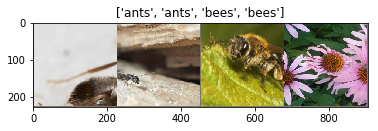

In [17]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the models 

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model


## Visualizing the model predictions

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)
                

## Finetuning the convnet

In [24]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [25]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4938 Acc: 0.7254
val Loss: 0.4042 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.4847 Acc: 0.7951
val Loss: 0.2805 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.3524 Acc: 0.8770
val Loss: 0.3455 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.5857 Acc: 0.7705
val Loss: 0.3081 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5541 Acc: 0.7623
val Loss: 0.2799 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.5175 Acc: 0.8320
val Loss: 0.4362 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.6925 Acc: 0.7869
val Loss: 0.3759 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.4067 Acc: 0.8279
val Loss: 0.1957 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3170 Acc: 0.8811
val Loss: 0.1891 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3584 Acc: 0.8443
val Loss: 0.1995 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3880 Acc: 0.8197
val Loss: 0.1976 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2964 Acc: 0.8484
val Loss: 0.1710 Acc: 0.9346

Ep

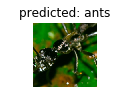

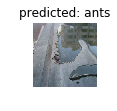

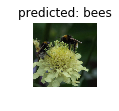

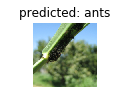

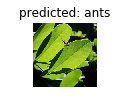

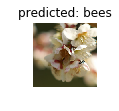

In [28]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [32]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [33]:
model_conv = train_model(model_conv, criterion, optimizer_conv, 
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5972 Acc: 0.6639
val Loss: 0.2325 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4990 Acc: 0.7910
val Loss: 0.3064 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.6518 Acc: 0.7336
val Loss: 0.3186 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.6192 Acc: 0.7787
val Loss: 0.3421 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.3145 Acc: 0.8484
val Loss: 0.1826 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.5738 Acc: 0.7910
val Loss: 0.1758 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3618 Acc: 0.8484
val Loss: 0.1571 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.3686 Acc: 0.8484
val Loss: 0.1851 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3816 Acc: 0.8238
val Loss: 0.1950 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3442 Acc: 0.8525
val Loss: 0.1586 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3541 Acc: 0.8648
val Loss: 0.1573 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3805 Acc: 0.8361
val Loss: 0.1603 Acc: 0.9542

Ep

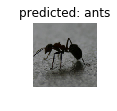

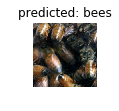

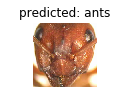

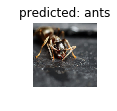

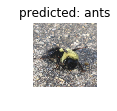

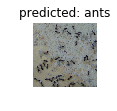

In [34]:
visualize_model(model_conv)

plt.ioff()
plt.show()